In [1]:
!pip -q install scikit-learn pandas numpy matplotlib wordcloud nltk joblib
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import re, string, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords


STOPWORDS = set(stopwords.words('english'))


def clean_text(s: str) -> str:
s = str(s)
s = s.lower()
s = re.sub(r"http\S+|www\S+", " ", s)
s = re.sub(r"@\w+|#\w+", " ", s)
s = s.translate(str.maketrans('', '', string.punctuation))
s = re.sub(r"\d+", " ", s)
tokens = [w for w in s.split() if w not in STOPWORDS and len(w) > 2]
return " ".join(tokens)

In [25]:
path = '/content/Hotel_Reviews.csv' # TODO: change to your actual file


df = pd.read_csv(path, on_bad_lines='skip')
print("DataFrame loaded:")
print(df.head())
print(df.columns.tolist())


# --- Try to auto‑detect likely text & label columns ---
possible_text = [c for c in df.columns if 'review' in c.lower() or 'text' in c.lower() or 'comment' in c.lower()]
possible_label = [c for c in df.columns if 'sentiment' in c.lower() or 'label' in c.lower() or 'rating' in c.lower() or c.lower() in ['polarity']]
print('Detected text candidates:', possible_text)
print('Detected label candidates:', possible_label)


# Manually set text and label columns based on investigation
TEXT_COL_NEG = 'Negative_Review'
TEXT_COL_POS = 'Positive_Review'
LABEL_COL = 'Reviewer_Score'
print(f"Selected negative text column: {TEXT_COL_NEG}")
print(f"Selected positive text column: {TEXT_COL_POS}")
print(f"Selected label column: {LABEL_COL}")

# Drop neutral ratings (optional)
initial_rows = len(df)
if df[LABEL_COL].between(2.5, 3.5).any():
    df = df[~df[LABEL_COL].between(2.5, 3.5)].copy() # Added .copy()
print(f"Rows after dropping neutral ratings (2.5-3.5): {len(df)} (Dropped {initial_rows - len(df)})")


# Create separate dataframes for negative and positive reviews
df_neg = df[[TEXT_COL_NEG, LABEL_COL]].copy()
df_pos = df[[TEXT_COL_POS, LABEL_COL]].copy()

# Map ratings to binary labels for negative reviews (score < 4 is negative)
df_neg['label'] = np.where(df_neg[LABEL_COL] < 4, 'negative', 'positive') # Corrected condition for negative reviews
df_neg['text'] = df_neg[TEXT_COL_NEG].astype(str).apply(clean_text)
df_neg = df_neg[['text', 'label']]

# Map ratings to binary labels for positive reviews (score >= 4 is positive)
df_pos['label'] = np.where(df_pos[LABEL_COL] >= 4, 'positive', 'negative') # Corrected condition for positive reviews
df_pos['text'] = df_pos[TEXT_COL_POS].astype(str).apply(clean_text)
df_pos = df_pos[['text', 'label']]

# Combine negative and positive reviews
df_combined = pd.concat([df_neg, df_pos], ignore_index=True)


# Drop empties and filter for valid labels
initial_rows_combined = len(df_combined)
df_combined = df_combined[(df_combined['text'].str.strip()!='') & (df_combined['label'].isin(['positive','negative']))].dropna(subset=['text','label'])
print(f"Rows after dropping empty text or invalid labels: {len(df_combined)} (Dropped {initial_rows_combined - len(df_combined)})")


df = df_combined # Update df to the combined and filtered dataframe

print(df.head())
print('Class balance:\n', df['label'].value_counts())

DataFrame loaded:
                                       Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                   

In [26]:
X_train, X_temp, y_train, y_temp = train_test_split(
df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
X_valid, X_test, y_valid, y_test = train_test_split(
X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
len(X_train), len(X_valid), len(X_test)

(163326, 20416, 20416)

In [27]:
# Baseline TF‑IDF + Logistic Regression
pipe = Pipeline([
('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9)),
('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None))
])


pipe.fit(X_train, y_train)
print('Validation performance:')
print(classification_report(y_valid, pipe.predict(X_valid)))

Validation performance:
              precision    recall  f1-score   support

    negative       0.04      0.53      0.07       166
    positive       1.00      0.88      0.94     20250

    accuracy                           0.88     20416
   macro avg       0.52      0.71      0.50     20416
weighted avg       0.99      0.88      0.93     20416



In [30]:
param_grid = {
'tfidf__ngram_range': [(1,1), (1,2)],
'tfidf__min_df': [2, 5],
'tfidf__max_df': [0.85, 0.9, 0.95],
'clf__C': [0.5, 1, 2, 4]
}


gs = GridSearchCV(pipe, param_grid, scoring='f1_macro', cv=3, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
print('Best CV F1:', gs.best_score_)


best_model = gs.best_estimator_
print('Validation metrics (best model):')
print(classification_report(y_valid, best_model.predict(X_valid)))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best params: {'clf__C': 1, 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best CV F1: 0.4995458656551457
Validation metrics (best model):
              precision    recall  f1-score   support

    negative       0.04      0.48      0.07       166
    positive       1.00      0.89      0.94     20250

    accuracy                           0.89     20416
   macro avg       0.52      0.69      0.50     20416
weighted avg       0.99      0.89      0.93     20416



              precision    recall  f1-score   support

    negative       0.03      0.45      0.06       166
    positive       0.99      0.89      0.94     20250

    accuracy                           0.88     20416
   macro avg       0.51      0.67      0.50     20416
weighted avg       0.99      0.88      0.93     20416



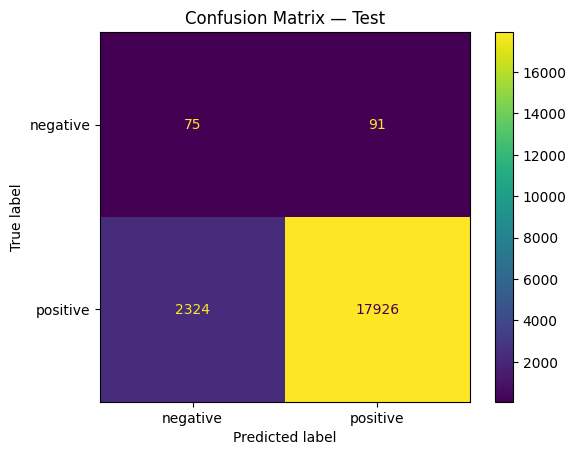

In [31]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=['negative','positive'])
ConfusionMatrixDisplay(cm, display_labels=['negative','positive']).plot()
plt.title('Confusion Matrix — Test')
plt.show()

In [32]:
vec: TfidfVectorizer = best_model.named_steps['tfidf']
clf: LogisticRegression = best_model.named_steps['clf']
feature_names = np.array(vec.get_feature_names_out())
coefs = clf.coef_[0]


# Top 20 for each class
n = 20
top_pos = feature_names[np.argsort(coefs)[-n:][::-1]]
top_neg = feature_names[np.argsort(coefs)[:n]]
print('Top positive tokens:', top_pos)
print('Top negative tokens:', top_neg)

Top positive tokens: ['bit' 'excellent' 'amazing' 'perfect' 'little' 'great' 'helpful staff'
 'fantastic' 'location friendly' 'clean room' 'staff good' 'nice staff'
 'choice' 'wonderful' 'location staff' 'loved' 'comfortable'
 'comfortable bed' 'modern' 'nice location']
Top negative tokens: ['dirty' 'breakfast excellent' 'bar comfortable' 'rather expensive'
 'building beautiful' 'price high' 'hot water' 'nice pillows'
 'concierge helpful' 'anything liked' 'rat' 'staff lovely'
 'special weekend' 'room quiet' 'office' 'space breakfast' 'great deal'
 'small comfortable' 'bad' 'lot']


In [33]:
joblib.dump(best_model, '/content/sentiment_pipeline.joblib')
print('Saved to /content/sentiment_pipeline.joblib')

Saved to /content/sentiment_pipeline.joblib


In [35]:
# Quick Sanity Check (Inference)

In [36]:
loaded = joblib.load('/content/sentiment_pipeline.joblib')
samples = [
'The room was clean and the staff were incredibly friendly',
'Worst stay ever — dirty sheets, broken AC, very noisy',
]
print(list(zip(samples, loaded.predict(samples))))

[('The room was clean and the staff were incredibly friendly', 'positive'), ('Worst stay ever — dirty sheets, broken AC, very noisy', 'negative')]


In [37]:
#Mini Web App (Streamlit)

In [41]:
# app.py
import joblib
import streamlit as st


st.set_page_config(page_title='Hotel Review Sentiment', page_icon='🏨')
st.title('🏨 Hotel Review Sentiment Classifier')


@st.cache_resource
def load_model():
    return joblib.load('sentiment_pipeline.joblib')


model = load_model()
review = st.text_area('Paste a hotel review:')
if st.button('Predict') and review.strip():
    pred = model.predict([review])[0]
    prob = None
    if hasattr(model.named_steps['clf'], 'predict_proba'):
        prob = model.predict_proba([review])[0]
    st.subheader(f'Prediction: {pred.upper()}')
    if prob is not None:
        st.write({ 'negative': float(prob[0]), 'positive': float(prob[1]) })

2025-08-19 19:47:43.766 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 19:47:43.779 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 19:47:43.992 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-19 19:47:43.993 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 19:47:43.994 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 19:47:43.996 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-19 19:47:43.999 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [40]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [42]:
#Folder Structure (Suggested)
#Project intro + dataset link.

#How to run notebook.
#How to save & load model.
#How to run Streamlit app.
#Results (test metrics screenshot + confusion matrix).
#Limitations & future work.

In [43]:
#Time Plan (typical)

In [44]:
##Day 1: Data import/cleaning, baseline model.
##Day 2: Tuning, test evaluation, error analysis.
##Day 3: Streamlit app + REA
